In [1]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

In [8]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [9]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [10]:
# Memory
# Stores results from the networks, instead of calculating the operations again from states, etc.
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
        

In [18]:
env = gym.make("LunarLander-v2")

In [19]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=5e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=5e-4)
gamma = 0.99
memory = Memory()
max_steps = 100

In [20]:
# train function
def train(memory, q_val):
    values = torch.stack(memory.values)
    q_vals = np.zeros((len(memory), 1))
    
    # target values are calculated backward
    # it's super important to handle correctly done states,
    # for those cases we want our to target to be equal to the reward only
    for i, (_, _, reward, done) in enumerate(memory.reversed()):
        q_val = reward + gamma*q_val*(1.0-done)
        q_vals[len(memory)-1 - i] = q_val # store values from the end to the beginning
        
    advantage = torch.Tensor(q_vals) - values
    
    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    
    actor_loss = (-torch.stack(memory.log_probs)*advantage.detach()).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

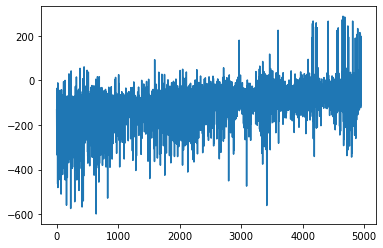

CPU times: user 32min 52s, sys: 45.9 s, total: 33min 38s
Wall time: 46min 17s


In [21]:
%%time
episode_rewards = []
f, ax = plt.subplots(1,1)
from IPython.display import clear_output

for i in range(5000):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0
    j=0

    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        
        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic(t(state)), reward, done)
        
        state = next_state
        
        # train if done or num steps > max_steps
        if done or (steps % max_steps == 0):
            last_q_val = critic(t(next_state)).detach().data.numpy()
            train(memory, last_q_val)
            memory.clear()
    
    episode_rewards.append(total_reward)
    if i%50 == 0:
        clear_output(True)
        print('\r' + str(len(episode_rewards)) + ' ' + str(np.mean(episode_rewards)), end='\r')
        plt.plot(episode_rewards)
        plt.show()

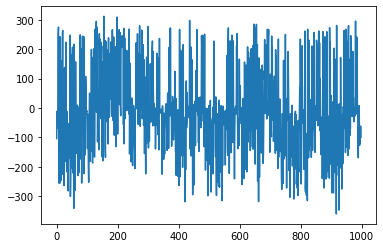

In [30]:
episode_rewards = []

for i in range(3000):
    done = False
    total_reward = 0
    state = env.reset()
    j = 0

    while not done and j<=1000:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, info = env.step(action.detach().data.numpy())
        advantage = reward + (1-done)*gamma*critic(t(next_state)) - critic(t(state))
        
        total_reward += reward
        state = next_state

        critic_loss = advantage.pow(2).mean()
        adam_critic.zero_grad()
        critic_loss.backward()
        adam_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        adam_actor.zero_grad()
        actor_loss.backward()
        adam_actor.step()
        j += 1
#         if j%2000 == 0:
    clear_output(True)
    print('\r' + str(len(episode_rewards)) + ' ' + str(np.mean(episode_rewards)), end='\r')
    plt.plot(episode_rewards)
    plt.show()    
    episode_rewards.append(total_reward)
    

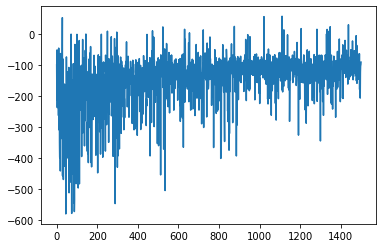

In [34]:
plt.plot(episode_rewards)
plt.show()

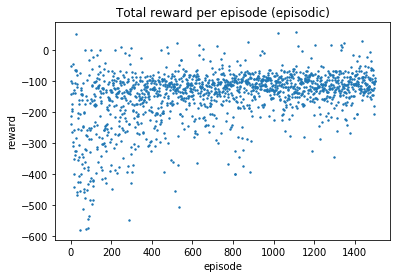

In [31]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (episodic)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

# Test A2C

In [22]:


tsteps=0
treward=0
frames = []
env.close()
for nexps in range(3):   # Let's do 10 trials
    done= False  
    observation = env.reset() 
    while not done:
        env.render()
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
#         action = model.act(observation, 0)
        observation, reward, done, info = env.step(action.numpy()) # take action from learned policy
        treward = treward + reward
        tsteps = tsteps + 1

In [54]:
env.close()

Episode 100, Average Reward -258.57
Episode 200, Average Reward -312.82
Episode 300, Average Reward -612.74
Episode 400, Average Reward -541.91
Episode 500, Average Reward -582.44
Episode 600, Average Reward -340.18
Episode 700, Average Reward -135.15
Episode 800, Average Reward -179.81
Episode 900, Average Reward -107.28
Episode 1000, Average Reward -127.02
Episode 1100, Average Reward -176.60
Episode 1200, Average Reward -133.91
Episode 1300, Average Reward -139.21
Episode 1400, Average Reward -137.42
Episode 1500, Average Reward -127.82
Episode 1600, Average Reward -136.28
Episode 1700, Average Reward -118.06
Episode 1800, Average Reward -264.09
Episode 1900, Average Reward -354.15
Episode 2000, Average Reward -203.65
Episode 2100, Average Reward -517.93
Episode 2200, Average Reward -139.34
Episode 2300, Average Reward -127.42
Episode 2400, Average Reward -118.40
Episode 2500, Average Reward -147.76
Episode 2600, Average Reward -144.02
Episode 2700, Average Reward -140.69
Episode 28

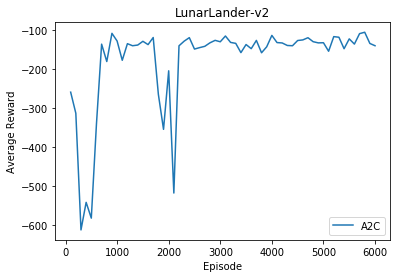

In [3]:
from A2C import A2C
from common.utils import agg_double_list

import sys
import gym
import numpy as np
import matplotlib.pyplot as plt


MAX_EPISODES = 3000*2 
EPISODES_BEFORE_TRAIN = 0
EVAL_EPISODES = 10 # 10
EVAL_INTERVAL = 100#100

# roll out n steps
ROLL_OUT_N_STEPS = 5
# only remember the latest ROLL_OUT_N_STEPS
MEMORY_CAPACITY = 1000#ROLL_OUT_N_STEPS
# only use the latest ROLL_OUT_N_STEPS for training A2C
BATCH_SIZE = 64# ROLL_OUT_N_STEPS

REWARD_DISCOUNTED_GAMMA = 0.99
ENTROPY_REG = 0.012501 #0
#
DONE_PENALTY = 0 #None #10 #-10.

CRITIC_LOSS = "mse"
MAX_GRAD_NORM = None

EPSILON_START = 0.99
EPSILON_END = 0.05
EPSILON_DECAY = 100

HIDDEN_SIZE = 32

RANDOM_SEED = 2017
A_LR = 1e-3
C_LR = 1e-3


env_id="LunarLander-v2"

env = gym.make(env_id)
env.seed(RANDOM_SEED)
env_eval = gym.make(env_id)
env_eval.seed(RANDOM_SEED)
state_dim = env.observation_space.shape[0]
if len(env.action_space.shape) > 1:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

a2c = A2C(env=env, memory_capacity=MEMORY_CAPACITY,
          state_dim=state_dim, action_dim=action_dim,
          batch_size=BATCH_SIZE, entropy_reg=ENTROPY_REG,
          done_penalty=DONE_PENALTY, roll_out_n_steps=ROLL_OUT_N_STEPS,
          reward_gamma=REWARD_DISCOUNTED_GAMMA,
          epsilon_start=EPSILON_START, epsilon_end=EPSILON_END,
          epsilon_decay=EPSILON_DECAY, max_grad_norm=MAX_GRAD_NORM,
          episodes_before_train=EPISODES_BEFORE_TRAIN,
          critic_loss=CRITIC_LOSS, actor_lr=A_LR, critic_lr=C_LR,
          actor_hidden_size=HIDDEN_SIZE, critic_hidden_size=HIDDEN_SIZE,
          optimizer_type='adam'
         )

episodes =[]
eval_rewards =[]
while a2c.n_episodes < MAX_EPISODES:
    a2c.interact()
    if a2c.n_episodes >= EPISODES_BEFORE_TRAIN:
        a2c.train()
    if a2c.episode_done and ((a2c.n_episodes+1)%EVAL_INTERVAL == 0):
        rewards, _ = a2c.evaluation(env_eval, EVAL_EPISODES)
        rewards_mu, rewards_std = agg_double_list(rewards)
        print("Episode %d, Average Reward %.2f" % (a2c.n_episodes+1, rewards_mu))
        episodes.append(a2c.n_episodes+1)
        eval_rewards.append(rewards_mu)
        if rewards_mu > 220:
            break

episodes = np.array(episodes)
eval_rewards = np.array(eval_rewards)
#     np.savetxt("./output/%s_a2c_episodes.txt"%env_id, episodes)
#     np.savetxt("./output/%s_a2c_eval_rewards.txt"%env_id, eval_rewards)

plt.figure()
plt.plot(episodes, eval_rewards)
plt.title("%s"%env_id)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(["A2C"])
#     plt.savefig("./output/%s_a2c.png"%env_id)

# run()

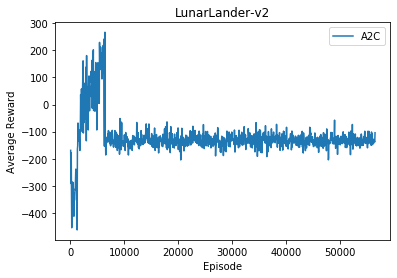

In [13]:
plt.figure()
plt.plot(episodes, eval_rewards)
plt.title("%s"%env_id)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(["A2C"])

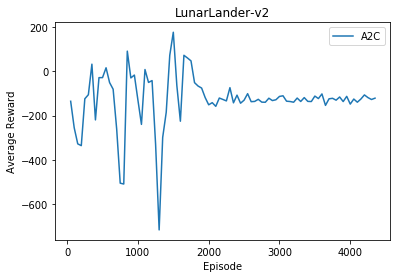

In [23]:
plt.figure()
plt.plot(episodes, eval_rewards)
plt.title("%s"%env_id)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(["A2C"])

In [2]:
len(eval_rewards)

60

In [4]:

tsteps=0
treward=0
frames = []
env.close()
for nexps in range(3):   # Let's do 10 trials
    done= False  
    observation = env.reset()
    while not done:
        env.render()
#         probs = actor(t(state))
#         dist = torch.distributions.Categorical(probs=probs)
#         action = dist.sample()
#         action = model.act(observation, 0)
        action = a2c.action(observation)
        observation, reward, done, info = env.step(action) # take action from learned policy
        treward = treward + reward
        tsteps = tsteps + 1
env.close()
print(treward)

-344.60400513349214
